In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import floor, ceil

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'narrow_search_factor'
model_type = 'place_field_ablation'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes2/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes2/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes2/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
load = True

In [6]:
if load:
    with open(f'resolution_{model_type}.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    summary_stats = {}

    for param in os.listdir(exp_dir):
        if param == '.DS_Store': continue
        dirpath = os.path.join(exp_dir, param)
        for site_spacing in os.listdir(dirpath):
            if not site_spacing.startswith('res'): continue    
            dirpath = os.path.join(exp_dir, param, site_spacing)
            for seed in os.listdir(dirpath):
                if not seed.startswith('seed'): continue
                dirpath = os.path.join(exp_dir, param, site_spacing, seed)
                _param = round(float(param), 1)
                _seed = int(seed[4:])
                _site_spacing = int(site_spacing[3:])
                cache_states = [0, _site_spacing, 66]
                try:
                    with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                        _results = pickle.load(f)
                except:
                    continue
                readout = _results['seed_reconstruct'].flatten()
                readout /= readout.max()
                reconstruct = _results['narrow_reconstruct']
                activations = _results['narrow_acts'].copy()
                _summary_stats = get_resolution_summary_statistics(
                    readout, reconstruct, cache_states, activations,
                    inputs, _site_spacing, search_strength=_param)
                for key, _dict in _summary_stats.items():
                    n_samples = len(_dict[list(_dict.keys())[0]])
                    if key not in summary_stats.keys():
                        summary_stats[key] = _dict
                    else:
                        for nested_key in _dict.keys():
                            summary_stats[key][nested_key].extend(_dict[nested_key])

    with open(f'pickles/resolution_{model_type}.p', 'wb') as f:
        pickle.dump(summary_stats, f)

/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:121: RuntimeWarning: invalid value encountered in greater
  high_readout = (readout > 0.5).tolist()


# Identifying the Presence of a Cache

### Sensitivity/Specificity at different thresholds

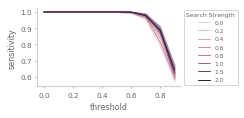

In [40]:
df = pd.DataFrame(summary_stats['identification_1'])
fig, ax = plt.subplots(figsize=(3.5,1.75))
sns.lineplot(
    x='threshold', y='sensitivity', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(
    title='Search Strength',
    loc='center left', labels=formatted_labels,
    bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.savefig('figures/fig5sf.png', dpi=300)
plt.show()

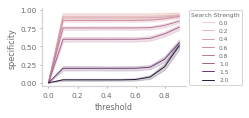

In [41]:
df = pd.DataFrame(summary_stats['identification_1'])
fig, ax = plt.subplots(figsize=(3.5,1.75))
sns.lineplot(
    x='threshold', y='specificity', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(
    title='Search Strength',
    loc='center left', labels=formatted_labels,
    bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.savefig('figures/fig5sg.png', dpi=300)
plt.show()

### Performance on caches

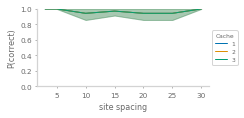

In [43]:
df = pd.DataFrame(summary_stats['identification_3'])
df = df[df['search strength'] == 0.]
df['binarized'] = df['val'] > 0.5
fig, ax = plt.subplots(figsize=(3.5,1.75))
sns.lineplot(
    x='site spacing', y ='binarized',
    hue='cache', data=df, palette=['C0', 'C1', 'C2']
    )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(
    title='Cache',
    loc='center left', labels = [1,2,3],
    bbox_to_anchor=(1, 0.5), fontsize=6)
plt.ylabel('P(correct)')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('figures/fig5sh.png', dpi=300)
plt.show()

# Reconstruction

### Probability of valid attractor given optimal attractor distance

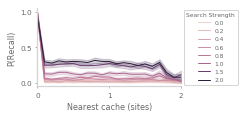

In [44]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df['site spacing']>15]
df['val'] = df['is_closest'] & df['high_readout']
fig, ax = plt.subplots(figsize=(3.5,1.75))
sns.lineplot(
    x='distance from closest cache', y='val', hue='search strength',
    data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(
    title='Search Strength',
    loc='center left', labels=formatted_labels,
    bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.ylabel('P(Recall)')
plt.xlabel('Nearest cache (sites)')
plt.yticks([0, 0.5, 1.0])
plt.xticks([0, 10, 20], [0,1,2])
plt.xlim([0, 20])
plt.tight_layout()
plt.savefig('figures/fig5si.png', dpi=300)
plt.show()